In [2]:
import inferno
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable

In [3]:
from sine_data import train_dataset, valid_dataset

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import insp

In [5]:
import visdom
vis = visdom.Visdom()

In [6]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [7]:
class InhCWRNN(nn.Module):
    def __init__(self, input_dim, output_dim, num_modules, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_modules = num_modules
        
        self.input_mod = nn.Linear(input_dim, output_dim)
        self.hidden_mod = nn.Linear(output_dim, output_dim, bias=False)
        
        #self.module_periods = nn.Parameter(torch.zeros(output_dim) + 1)
        #self.module_shifts = nn.Parameter(torch.zeros(output_dim))
        self.module_periods = nn.Parameter(torch.zeros(num_modules) + 1)
        self.module_shifts = nn.Parameter(torch.zeros(num_modules))
        
        self.f_mod = nn.Tanh()        
        
    def step(self, ti, xi, h):
        module_size = self.output_dim // self.num_modules
        
        acts = self.f_mod(self.input_mod(xi) + self.hidden_mod(h))
        module_acts = acts.view(-1, self.num_modules, module_size)
                
        gate = torch.sin(ti * self.module_periods + self.module_shifts)
        gate = gate.view(1, -1, 1).expand_as(module_acts).contiguous()
        gate = gate.view(-1, self.output_dim)
                
        y = (1 - gate) * acts + gate * h
        
        return y, y
        
    def init_hidden(self):
        return Variable(torch.zeros(self.output_dim))
        
    def forward(self, x):
        t = x.size(1)
        ys = []
        h = self.init_hidden()
        for ti in range(t):
            xi = x[:, ti]
            yi, h = self.step(ti, xi, h)            
            ys.append(yi)
        return torch.stack(ys, dim=1), h

In [8]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [9]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, num_modules=8):
        super().__init__()
        
        self.rnn = InhCWRNN(1, num_hidden, num_modules)
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0 = self.rnn(x)
        
        vis.heatmap(l0[0].data.numpy(), win="act")
        vis.heatmap(self.rnn.module_periods.data.numpy().reshape(1, -1), win="periods")
        vis.heatmap(self.rnn.module_shifts.data.numpy().reshape(1, -1), win="shifts")

        l1 = self.clf(time_flatten(l0))
        return time_unflatten(l1, x.size())

In [10]:
class Trainer(inferno.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

### exp inhibition

In [15]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_relu = Trainer(module=ReconModel,
             optim=torch.optim.Adam,
             lr=0.005,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_modules=8,
             module__num_hidden=64,
            )

In [16]:
%pdb on
ef_relu.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.8167        0.8152  0.5352
      2        0.8067        0.3912  0.6044
      3        0.3632        0.2538  0.5810
      4        0.2269        0.1852  0.5815
      5        0.1724        0.1126  0.6528
      6        0.1130        0.0765  0.5841
      7        0.0822        0.0991  0.6747
      8        0.1027        0.1281  0.6449
      9        0.1289        0.1152  0.5538
     10        0.1161        0.0698  0.7369
     11        0.0737        0.0288  0.6126
     12        0.0351        0.0150  0.6216
     13        0.0220        0.0256  0.6047
     14        0.0316        0.0419  0.5831
     15        0.0462        0.0488  0.7130
     16        0.0516        0.0446  0.5711
     17        0.0464        0.0367  0.6025
     18        0.0383        0.0326  0.6380
     19        0.0344        0.0335  0.5873
     20        0.0356        0.0351

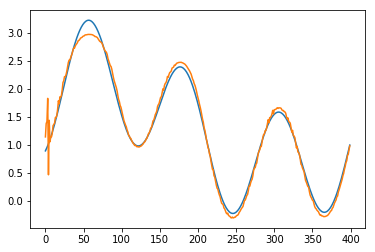

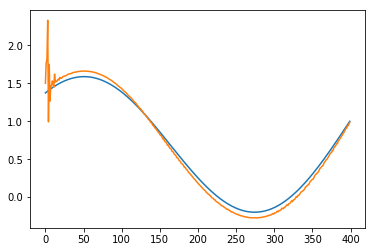

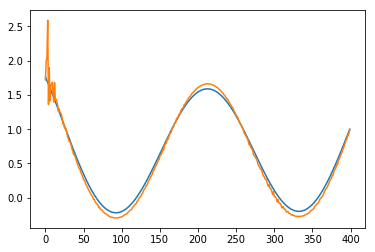

In [17]:
data = X_valid
pred = ef_relu.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])